In [1]:

"""
Library and utility import
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import torch
import torch.nn as nn
import zutils
import pandas as pd

In [3]:
"""
Check for GPU availability
"""
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


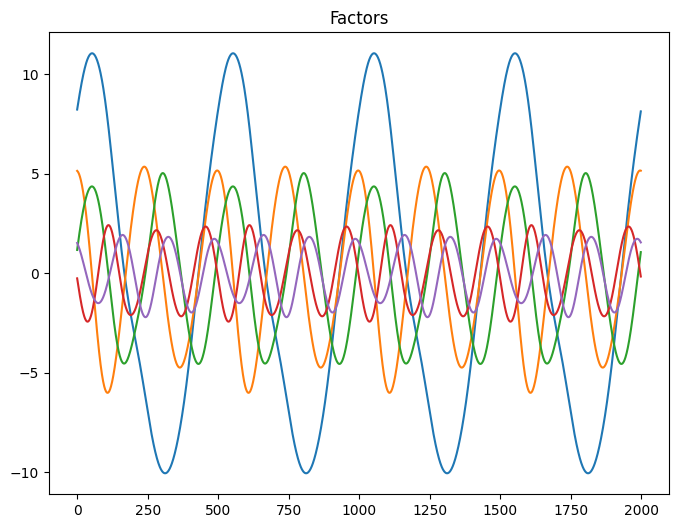

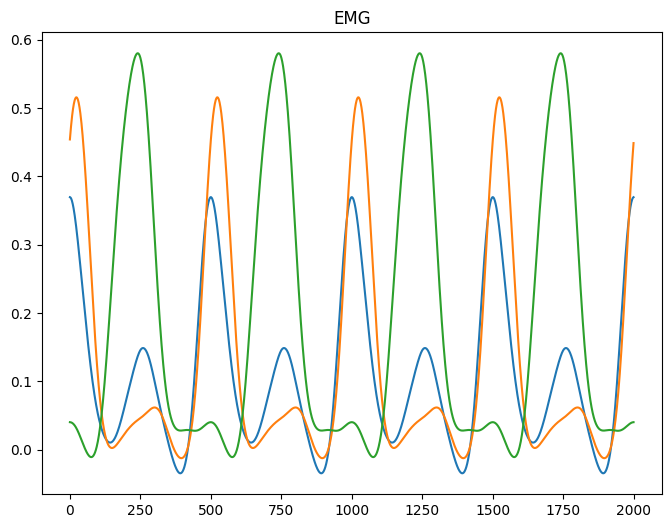

In [4]:
"""
Load in the data and move to device
"""

factors_df = pd.read_csv("./Depaq-Data/Cycling/factors.csv", header=None)
emg_df = pd.read_csv("./Depaq-Data/Cycling/emg.csv", header=None)

factors = torch.tensor(factors_df.values, dtype=torch.float)
emg = torch.tensor(emg_df.values, dtype=torch.float)

factors = factors.to(device)
emg = emg.to(device)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.plot(factors[:,[1,2,3,4,5]])
plt.title("Factors")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(emg[:,[0,1,2]])
plt.title("EMG")
plt.show()

In [215]:
time_step = 1e-3
nb_hidden = 800

# Parameters do define J_0, U, and W_in
g_f = 0.13
g_s = 0.11
g = 3.0
mu_f = -0.3
mu_s = 0

m_in = 1  # number of inputs
utilde_in = -1 + 2*torch.rand(nb_hidden, m_in)  # Input weights for external input

# all to define orthonmal V, which is mapping of factors to hidden neurons
A = -1 + 2 * torch.rand(nb_hidden, 12)
Q, R = torch.linalg.qr(A, mode='reduced')
V = Q


U = g * torch.ones(nb_hidden, nb_hidden)  # Maps N to N
u_in = U @ utilde_in  # input weights for external inputs into spiking model
u = U @ V  # mapping from P space to N space


# Section for demeaning, trying to modify Brian's code into python
Tinit = 50;
DTRLS = 2;
tau_mem = 10e-3  # tauv
tau_syn_f = 5e-3  # tauf
tau_syn_s = 100e-3  # taus
vth = 1e-16;
vr = -10;


alpha_f   = float(np.exp(-time_step/tau_syn_f))  # etauf
alpha_s   = float(np.exp(-time_step/tau_syn_s))  # etaus
beta    = float(np.exp(-time_step/tau_mem))      # etauv

# Mean recurrent matrix in factor approximating network for spiking neurons
Jmu = mu_f * (1/tau_syn_f) * 1/(nb_hidden) * torch.ones(nb_hidden, nb_hidden);

# Random fast and slow connections for non factor related activity
J0f = g_f * (1/tau_syn_f) * 1/np.sqrt(nb_hidden) * torch.randn(nb_hidden, nb_hidden);
J0s = g_s * (1/tau_syn_s) * 1/np.sqrt(nb_hidden) * torch.randn(nb_hidden, nb_hidden);

# Get factors and emg data and numbers
factors;
emg;
m=3
P=12

# If demean mode line 120 spiking_network.m
sum_vJsbar = torch.zeros(nb_hidden,1)
vJsbar = torch.zeros(nb_hidden,1)

# Initialize the state variables
y = torch.zeros(P,1)  # Learned input current
ss = torch.zeros(nb_hidden,1)  # Slow presynaptic current
sf = torch.zeros(nb_hidden,1)  # Fast presynaptic current

v = 1e-3 * torch.rand(nb_hidden,1)  # Spike network state
J0ss = torch.zeros(nb_hidden,1)  # Slow synaptic current
J0fs = torch.zeros(nb_hidden,1)  # Fast synaptic current
J0fbars = torch.zeros(nb_hidden,1)  # J0 mean current

In [153]:
J0ss.size()

torch.Size([800, 1])

In [89]:
def trial_cycling(dt):
    event = torch.tensor([0.05, 1.95]) * (1 / dt)  # shape (2,)

    TTrial = int(event.sum().item())  # total trial duration as int

    # Define input windows
    event0_len = int(event[0].item())
    event1_len = int(event[1].item())

    # Create input pulses
    fin1 = 2.0 * torch.ones(1, event0_len)
    fin2 = torch.zeros(1, event1_len)

    fin = torch.cat((fin1, fin2), dim=1)  # shape (1, event0_len + event1_len)

    return fin, TTrial


In [138]:
J0fs.size()

torch.Size([800, 1])

In [229]:
# Loop variables
T = 100  # number of trials to use for demeaning
ttrial = 1e10; # time in current trial
TTrial = 0; # total time in current trial
t_trial_num = 0; # trial number
ttime = 1; # time across all trials
go = True; # flag to quit loop
nplt = 3  # Number of factors to show
vth = 10  # mV
v = 1e-3 * torch.rand(nb_hidden,1)  # Spike network state

while go:
    if ttrial > TTrial-1:
        ttrial = 0 # Reset trial time
        t_trial_num += 1  # Increment trial counter

        print(t_trial_num)

        # Case cycling line 242 spiking_network.m
        fin, TTrial = trial_cycling(time_step)
        ytilde = factors.T
        f = emg.T

        # line 263
        zs = torch.zeros(m, TTrial)  # EMG for plotting
        vs = torch.zeros(nplt, TTrial)   # Factors? for plotting
        ys = torch.zeros(P, TTrial)  # something for plotting
        zsT = torch.zeros(nb_hidden,TTrial)  # collecting recurrent inputs for mean computation
    # end if

    # integrate factor approximating model line 284
    a = u_in * fin[:,ttrial]
    vinf = J0fbars - vJsbar + u @ y + J0ss + J0fs + u_in * fin[:,ttrial]
    v = vinf + (v-vinf)*beta

    

    S = (v >= vth).int()  # spikes
    v[S] = vth + vr  # reset

    J0ss = J0ss*alpha_s + J0s[:, S].sum(dim=1)
    J0fs = J0fs*alpha_f + J0f[:, S].sum(dim=1)
    J0fbars = J0fbars*alpha_f + Jmu[:, S].sum(dim=1)

    # Make presynaptic currents and concatenate
    ss = alpha_s*ss + S
    sf = alpha_f*sf + S
    s = torch.cat((ss,sf))

    
    if t_trial_num > Tinit:
        # case demean
        y = ytilde[:,ttrial].unsqueeze(1)  # use factor targets as feedback
        z = f[:,ttrial].unsqueeze(1)

    else:
        y = ytilde[:,ttrial].unsqueeze(1)  # use factor targets as feedback
        z = f[:,ttrial].unsqueeze(1)
    # end if
    zs[:,ttrial] = z.squeeze()  # outputs
    ys[:,ttrial] = y.squeeze()  # factors

    vs[:, ttrial] = v[1:nplt+1, 0]
    vs[S[1:nplt], ttrial] = 2 * (vth-vr)

    zsT[:,ttrial] = u @ ytilde[:,ttrial] + J0ss.squeeze() + J0fs.squeeze()

    # line 329

    if t_trial_num > Tinit:
        
        if ttrial == TTrial:
            # demean line 366
            sum_vJsbar = sum_vJsbar + torch.sum(zsT, dim=1)
            [a,b] = zsT.size()
            vJsbar = sum_vJsbar / (ttime * b)
            ttime +=1
        # end if
    # end if


    # After initial period goes here

    if t_trial_num == T+Tinit and ttrial == TTrial:
        go = False

    ttrial += 1  

    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


KeyboardInterrupt: 

In [64]:
print(S.size(), ss.size())

torch.Size([800, 1]) torch.Size([12, 1])
